### Setting environment

In [ ]:
import numpy as np
import math
import os
from PIL import Image
import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Getting the data


### Download dataset



In [ ]:
# Download dataset from google drive
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'my_link' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=my_id" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! mkdir ./data && unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'my_link' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=my_id" -O calligraphy.zip && rm -rf /tmp/cookies.txt
! unzip -q calligraphy.zip -d ./data/ && rm calligraphy.zip
! ls -l ./data

### make dataset

In [ ]:
# !rm -r data

In [ ]:
# Model / data parameters
input_shape = (32, 32, 1)
batch_size = 32
data_dir = "./data/train_half"
test_dir = "./data/test_half"
data_name = "calligraphy"

In [ ]:
# dataset class
class CalligraphySequence(tf.keras.utils.Sequence):

    def __init__(self, image_dir, batch_size, raw_data):
        # self.batch_size = batch_size
        # self.image_dir = image_dir
        # self.image_list = os.listdir(image_dir)
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.image_list = os.listdir(image_dir)

        self.train_dir = None
        self.val_dir = None
        
        if raw_data == True:
          self.train_dir = os.path.join(image_dir, '../train_set')
          self.val_dir = os.path.join(image_dir, '../val_set')
          if not os.path.exists(self.train_dir):
              os.makedirs(self.train_dir)
          if not os.path.exists(self.val_dir):
              os.makedirs(self.val_dir)

          # Split the image files into train and test sets
          split_idx = int(len(self.image_list) * 0.8)
          self.train_list = self.image_list[:split_idx]
          self.test_list = self.image_list[split_idx:]

          # Copy train images to train_dir
          for filename in self.train_list:
              src_path = os.path.join(self.image_dir, filename)
              dst_path = os.path.join(self.train_dir, filename)
              self.copy_file(src_path, dst_path)

          # Copy test images to val_dir
          for filename in self.test_list:
              src_path = os.path.join(self.image_dir, filename)
              dst_path = os.path.join(self.val_dir, filename)
              self.copy_file(src_path, dst_path)

    def __len__(self):
        num_files = len([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        return math.ceil(num_files/batch_size)

    def __getitem__(self, idx):
        # Round all pixel values less than 33% of the max 256 value to 0
        # anything above this value gets rounded up to 1 so that all values are either
        # 0 or 1
        batch_list = self.image_list[idx * self.batch_size : (idx + 1) * self.batch_size]
        x_batch = np.zeros((len(batch_list), 32, 32, 1))
        y_batch = x_batch 
        
        for i, file_name in enumerate(batch_list):

            # Convert the images to gray scale
            # Resize the images to the size of 32 × 32 pixels
            img = keras.preprocessing.image.load_img(os.path.join(self.image_dir, file_name), color_mode='grayscale', target_size=(32, 32))

            # Normalize the images to ensure that all elements are in the range from 0 to 1.
            img = keras.preprocessing.image.img_to_array(img) / 255.0

            # Binarize the image. Assign a value 0 to a pixel if its intensity is less than 0.33. 
            # Otherwise, assign a value 1.
            img_binarized = np.where(img < 0.33, 0, 1)

            x_batch[i] = img_binarized
            y_batch[i] = x_batch[i]
        
        return x_batch, y_batch

    def copy_file(self, src, dst):
      with open(src, 'rb') as fsrc, open(dst, 'wb') as fdst:
          while True:
              buf = fsrc.read(1024)
              if not buf:
                  break
              fdst.write(buf)

    def get_train_set_dir(self):
      return self.train_dir
    
    def get_val_set_dir(self):
      return self.val_dir

# final shape should be 1313 (32, 32, 32, 1) (32, 32, 32, 1)
data_ds = CalligraphySequence(data_dir, batch_size, True)
print(len(data_ds), data_ds[0][0].shape, data_ds[0][1].shape)

# final shape should be 1050 (32, 32, 32, 1) (32, 32, 32, 1)
train_ds = CalligraphySequence(data_ds.get_train_set_dir(), batch_size, False)
print(len(train_ds), train_ds[0][0].shape, train_ds[0][1].shape)

# final shape should be 263 (32, 32, 32, 1) (32, 32, 32, 1)
val_ds = CalligraphySequence(data_ds.get_val_set_dir(), batch_size, False)
print(len(val_ds), val_ds[0][0].shape, val_ds[0][1].shape)

# final shape should be 329 (32, 32, 32, 1) (32, 32, 32, 1)
test_ds = CalligraphySequence(test_dir, batch_size, False)
print(len(test_ds), test_ds[0][0].shape, test_ds[0][1].shape)

1313 (32, 32, 32, 1) (32, 32, 32, 1)
1050 (32, 32, 32, 1) (32, 32, 32, 1)
263 (32, 32, 32, 1) (32, 32, 32, 1)
329 (32, 32, 32, 1) (32, 32, 32, 1)


## Create layers for the requisite Layers for the model


### Function for conv2d / down_shift / right_shift / concat_elu

In [ ]:
class Conv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[3, 3], stride=[1, 1], pad='SAME', nonlinearity=None, **kwargs):
        super().__init__()
        self.conv = layers.Conv2D(num_filters, filter_size, padding = pad, strides = stride, activation = nonlinearity, 
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))

    def call(self, x):
        return self.conv(x)

def down_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], step, input_shape[2], input_shape[3])), x[:, :input_shape[1] - step, :, :]], 1)

def right_move(x, step=1):
    input_shape = tf.shape(x)
    return tf.concat([tf.zeros((input_shape[0], input_shape[1], step, input_shape[3])), x[:, :, :input_shape[2] - step, :]], 2)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape()) - 1
    out = tf.nn.elu(tf.concat([x, -x], axis))
    return out

### Gated Residual Block

In [ ]:
class DownMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 3], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.pad = pad
        self.nonlinearity = nonlinearity

        self.conv = layers.Conv2D(
            num_filters, filter_size, strides=stride, padding=pad,
            activation=nonlinearity,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.05)
        )
        

    def call(self, x):
        pad_top = self.filter_size[0] - 1
        pad_width = int((self.filter_size[1] - 1) / 2)
        x = tf.pad(x, [[0, 0], [pad_top, 0], [pad_width, pad_width], [0, 0]])
        x = self.conv(x)
        if self.nonlinearity is not None:
            x = self.nonlinearity(x)
        return x


class DownRightMovedConv2d(layers.Layer):
    def __init__(self, num_filters, filter_size=[2, 2], stride=[1, 1], pad='VALID', nonlinearity=None, **kwargs):
        super().__init__()
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.stride = stride
        self.pad = pad
        self.nonlinearity = nonlinearity

        self.conv = layers.Conv2D(
            num_filters, filter_size, strides=stride, padding=pad,
            activation=nonlinearity,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.05)
        )

    def call(self, x):
        pad_top = self.filter_size[0] - 1
        pad_left = self.filter_size[1] - 1
        x = tf.pad(x, [[0, 0], [pad_top, 0], [pad_left, 0], [0, 0]])
        x = self.conv(x)
        if self.nonlinearity is not None:
            x = self.nonlinearity(x)
        return x


class TensorDense(layers.Layer):
    def __init__(self, num_units, nonlinearity=None, **kwargs):
        super().__init__()
        self.num_units = num_units
        self.nonlinearity = nonlinearity
        self.dense_layer = layers.Dense(
            num_units, activation=nonlinearity, 
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=0.05)
        )

    def call(self, x):
        input_shape = tf.shape(x) # shape = (B, H, W, C)

        # reshapes the input tensor to a 2-dimensional tensor of shape (B · H · W, C)
        reshaped = tf.reshape(x, [input_shape[0] * input_shape[1] * input_shape[2], input_shape[3]])
        
        # then applies a keras.layers.Dense layer to the reshaped tensor, producing a tensor of shape (B · H · W, num units)
        dense_output = self.dense_layer(reshaped) 
        
        # Finally, it reshapes the output tensor to (B, H, W, num units)
        output_shape = [input_shape[0], input_shape[1], input_shape[2], self.num_units]
        output = tf.reshape(dense_output, output_shape)

        if self.nonlinearity is not None:
            output = self.nonlinearity(output)
        return output


class GatedResnet(layers.Layer):
    def __init__(self, num_filters, nonlinearity=concat_elu, **kwargs):
        super().__init__()
        self.num_filters = num_filters
        self.nonlinearity = nonlinearity
        self.nnLayer_1 = DownRightMovedConv2d(num_filters=num_filters)
        self.nnLayer_2 = DownRightMovedConv2d(num_filters=num_filters*2)

    def call(self, x):
        oringal_x = x

        # Feature extraction with NN layers
        x_1 = self.nonlinearity(x)
        x_2 = self.nnLayer_1(x_1)
        x_3 = self.nonlinearity(x_2)
        x_4 = self.nnLayer_2(x_3)

        # Feature Gated Strategy
        feature_tensor, gate_weight = tf.split(value=x_4, num_or_size_splits=2, axis=3)
        gate_weight_sigmoid = tf.sigmoid(gate_weight)
        mul_product = tf.multiply(feature_tensor, gate_weight_sigmoid)

        # Residual Connection
        output = mul_product + oringal_x
        return output


### Main AutoregressiveModel

In [ ]:
class AutoregressiveModel(layers.Layer):
    def __init__(self, n_resnet=5, n_filters=256, n_block=12, n_output=10, **kwargs):
        super().__init__()
        self.n_resnet = n_resnet
        self.n_filters = n_filters
        self.n_block = n_block
        self.n_output = n_output
        # init all network layers
        self.down_moved_conv2d = DownMovedConv2d(num_filters=self.n_filters, filter_size=[1, 3])
        self.down_right_moved_conv2d = DownRightMovedConv2d(num_filters=self.n_filters, filter_size=[2, 1])
        self.out_dense = TensorDense(self.n_output)
        self.ul_list_gated_resnet = []
        self.ul_list_dense_layer = []

        self.M = 6
        self.N = 6
        for i in range(self.M):
          self.ul_list_dense_layer.append(TensorDense(num_units=self.n_filters))
          N_resnet_list = []
          for j in range(self.N):
            N_resnet_list.append(GatedResnet(num_filters=self.n_filters))
          self.ul_list_gated_resnet.append(N_resnet_list)

          
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        x = down_move(self.down_moved_conv2d(inputs)) + right_move(self.down_right_moved_conv2d(inputs))
        # The output from the previous step passes through a NetworkBlock
        # which consists of N GatedResnets and one layer of TensorDense.
        network_block_output = None
        first_block = True
        for i in range(self.M):
          if first_block:
            network_block_output = self.NetworkBlock(x, i)
            first_block = False
          else:
            network_block_output = self.NetworkBlock(network_block_output, i)

        elu_output = tf.nn.elu(network_block_output)
        x_out = self.out_dense(elu_output)
        
        return x_out

    def NetworkBlock(self, inputs, n_M):
      first_block = True
      resnet_output = None
      for i in range(self.N):
        if first_block:
          resnet_output = self.ul_list_gated_resnet[n_M][i](inputs)
          first_block = False
        else:
          resnet_output = self.ul_list_gated_resnet[n_M][i](resnet_output)

      dense_output = self.ul_list_dense_layer[n_M](resnet_output)

      return dense_output

## Build the model


In [ ]:
inputs = keras.Input(shape=input_shape, dtype=tf.float32)
x = AutoregressiveModel(n_resnet=6, n_filters=64, n_block=6, n_output=10)(inputs)
out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

adam = keras.optimizers.Adam(
    learning_rate=0.0001, 
    beta_1=0.95, 
    beta_2=0.9995, 
    epsilon=1e-6, 
    use_ema=True, 
    ema_momentum=0.9995
)
pixel_cnn.compile(
    optimizer=adam, 
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

pixel_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 autoregressive_model_1 (Aut  (None, 32, 32, 10)       3571914   
 oregressiveModel)                                               
                                                                 
 conv2d_149 (Conv2D)         (None, 32, 32, 1)         11        
                                                                 
Total params: 3,571,925
Trainable params: 3,571,925
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train before load weight
test_loss_no_load, test_accuracy_no_load  = pixel_cnn.evaluate(test_ds)
print(test_loss_no_load, test_accuracy_no_load)

329/329 [==============================] - 48s 137ms/step - loss: 0.6972 - accuracy: 0.3054
0.6972017288208008 0.30542802810668945


In [ ]:
# ! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'my_link' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=my_id" -O pixel_cnn_e5.h5 && rm -rf /tmp/cookies.txt
pixel_cnn.load_weights('pixel_cnn_e5.h5')

test_loss_after_load, test_accuracy_after_load = pixel_cnn.evaluate(test_ds)
print(test_loss_after_load, test_accuracy_after_load)

--2023-04-02 05:17:58--  https://docs.google.com/uc?export=download&confirm=&id=1-WTf4MA97yqSvId56b3YuAO3kDraA9TS
Resolving docs.google.com (docs.google.com)... 173.194.192.100, 173.194.192.102, 173.194.192.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.192.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1a6r6hl1q4ojs9chgp3673tedltdg82v/1680412650000/03901551524224365685/*/1-WTf4MA97yqSvId56b3YuAO3kDraA9TS?e=download&uuid=3c276838-a8ca-463d-9640-2610c656f8ca [following]
--2023-04-02 05:18:01--  https://doc-0o-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1a6r6hl1q4ojs9chgp3673tedltdg82v/1680412650000/03901551524224365685/*/1-WTf4MA97yqSvId56b3YuAO3kDraA9TS?e=download&uuid=3c276838-a8ca-463d-9640-2610c656f8ca
Resolving doc-0o-cc-docs.googleusercontent.com (doc-0o-cc-docs.googleusercontent.com)... 74.125.132.13

In [ ]:
# train after load weight
fitted_model = pixel_cnn.fit(
    train_ds,
    callbacks=callbacks,
    batch_size=32, # batch size for training
    epochs=10, # number of epochs to train
    validation_data=val_ds # validation data and labels
)

Epoch 1/10
1050/1050 [==============================] - 513s 453ms/step - loss: 0.1991 - accuracy: 0.9169 - val_loss: 0.1977 - val_accuracy: 0.9176
Epoch 2/10
1050/1050 [==============================] - 476s 453ms/step - loss: 0.1974 - accuracy: 0.9177 - val_loss: 0.1967 - val_accuracy: 0.9181
Epoch 3/10
1050/1050 [==============================] - 475s 453ms/step - loss: 0.1962 - accuracy: 0.9183 - val_loss: 0.1969 - val_accuracy: 0.9177
Epoch 4/10
1050/1050 [==============================] - 475s 453ms/step - loss: 0.1952 - accuracy: 0.9187 - val_loss: 0.1950 - val_accuracy: 0.9188
Epoch 5/10
1050/1050 [==============================] - 475s 453ms/step - loss: 0.1942 - accuracy: 0.9192 - val_loss: 0.1948 - val_accuracy: 0.9188
Epoch 6/10
1050/1050 [==============================] - 476s 453ms/step - loss: 0.1934 - accuracy: 0.9196 - val_loss: 0.1937 - val_accuracy: 0.9195
Epoch 7/10
1050/1050 [==============================] - 475s 453ms/step - loss: 0.1925 - accuracy: 0.9200 - val_

In [ ]:
# save weights 
pixel_cnn.save_weights('pixel_cnn_e15.h5')

## Demonstration

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 1/32 [00:04<02:21,  4.55s/it]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 2/32 [00:08<02:05,  4.17s/it]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 3/32 [00:12<01:57,  4.05s/it]

1/1 [==============================] - 0s 32ms/step


 12%|█▎        | 4/32 [00:16<01:56,  4.16s/it]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 5/32 [00:20<01:48,  4.01s/it]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 6/32 [00:24<01:41,  3.92s/it]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 7/32 [00:28<01:41,  4.07s/it]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 8/32 [00:32<01:34,  3.95s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 9/32 [00:35<01:29,  3.88s/it]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 10/32 [00:40<01:28,  4.03s/it]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 11/32 [00:44<01:22,  3.91s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 12/32 [00:47<01:17,  3.86s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 13/32 [00:52<01:15,  3.99s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 14/32 [00:55<01:09,  3.86s/it]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 15/32 [00:59<01:07,  3.98s/it]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 16/32 [01:04<01:05,  4.07s/it]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 17/32 [01:07<00:58,  3.93s/it]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 18/32 [01:11<00:53,  3.83s/it]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 19/32 [01:15<00:50,  3.86s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▎   | 20/32 [01:19<00:47,  3.92s/it]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 21/32 [01:22<00:41,  3.82s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 22/32 [01:26<00:37,  3.77s/it]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 23/32 [01:30<00:35,  3.92s/it]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 24/32 [01:34<00:30,  3.84s/it]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 25/32 [01:38<00:26,  3.78s/it]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 26/32 [01:42<00:23,  3.93s/it]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 27/32 [01:45<00:19,  3.81s/it]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 28/32 [01:49<00:15,  3.75s/it]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 29/32 [01:53<00:11,  3.89s/it]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 30/32 [01:57<00:07,  3.82s/it]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 31/32 [02:01<00:03,  3.79s/it]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 32/32 [02:05<00:00,  3.91s/it]


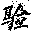

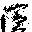

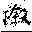

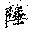

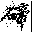

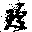

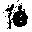

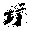

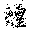

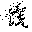

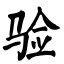

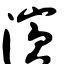

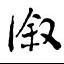

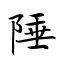

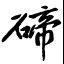

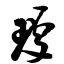

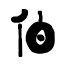

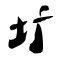

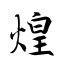

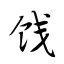

In [ ]:
from IPython.display import Image as IDImage, display

# Create an empty array of pixels.
batch = 10
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            probs = pixel_cnn.predict(test_ds[0][0][0:batch])
            # pixels[:, row, col, channel] = tf.math.ceil(probs[:, row, col, channel ] - tf.random.uniform((batch,), minval=0, maxval=1))
            pixels[:, row, col, channel] = tf.math.ceil(probs[:, row, col, channel] - tf.random.uniform((batch,), minval=0, maxval=0.5) - tf.constant(0.5))


def deprocess_image(x):
    # Stack the single channeled black and white image to RGB values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(IDImage("generated_image_0.png"))
display(IDImage("generated_image_1.png"))
display(IDImage("generated_image_2.png"))
display(IDImage("generated_image_3.png"))
display(IDImage("generated_image_4.png"))
display(IDImage("generated_image_5.png"))
display(IDImage("generated_image_6.png"))
display(IDImage("generated_image_7.png"))
display(IDImage("generated_image_8.png"))
display(IDImage("generated_image_9.png"))

# show orignal images
for file_name in os.listdir(test_ds.image_dir)[:batch]:
    image_path = os.path.join(test_ds.image_dir, file_name)
    image = Image.open(image_path)
    image.show()

## Quantitative Evaluation



In [ ]:
print(test_loss_no_load, test_accuracy_no_load)
print(test_loss_after_load, test_accuracy_after_load)

test_loss_after_fit, test_accuracy_after_fit = pixel_cnn.evaluate(test_ds)
print(test_loss_after_fit, test_accuracy_after_fit)

0.6972017288208008 0.30542802810668945
0.202795147895813 0.9156996607780457
329/329 [==============================] - 45s 137ms/step - loss: 0.1927 - accuracy: 0.9200
0.19266654551029205 0.9199774861335754
